In [9]:
from sklearn import metrics

from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#parameters
batch_size = 32
im_size = 224 #
test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
!cp '/content/drive/My Drive/training_data.zip' .
!unzip training_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_data/train/melanocytic_nevi/ISIC_0030421.jpg  
  inflating: training_data/train/melanocytic_nevi/ISIC_0030422.jpg  
  inflating: training_data/train/melanocytic_nevi/ISIC_0030425.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030426.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030428.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030429.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030430.jpg  
  inflating: training_data/train/melanocytic_nevi/ISIC_0030431.jpg  
  inflating: training_data/train/melanocytic_nevi/ISIC_0030432.jpg  
  inflating: training_data/train/melanocytic_nevi/ISIC_0030434.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030435.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030437.jpg  
 extracting: training_data/train/melanocytic_nevi/ISIC_0030438.jpg  
 extracting: training_data/train/melanocytic_nevi/IS

In [7]:
test_data = torchvision.datasets.ImageFolder(root = 'training_data/val/', transform = test_transforms)
test_loader = DataLoader(test_data, batch_size= batch_size)
dataloaders = {'test':test_loader}
classes = test_data.classes
criterion = nn.CrossEntropyLoss()

In [28]:
## GEt model
!cp '/content/drive/My Drive/model.pt' .
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_ft.to(device)
model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [25]:
!ls

drive  model.pt  sample_data  training_data  training_data.zip


In [29]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    with open("metrics.txt","w") as txtfile:
        strr = " Prediction: " + str(precision*100)+" Recall: "  + str(recall*100) +" Accuracy: " + str(accuracy*100) +" F1 Score: " + str(f1_score*100)
        txtfile.write(strr)
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

tensor(0.8631, device='cuda:0', dtype=torch.float64) 0.36385544892104843
Precision: 76.61822474631903 Recall: 76.92766418188867, Accuracy: 87.0: ,f1_score: 76.3834567996227
Confusion matrix, without normalization
[[  84    2    8    1    4    3    0]
 [   3  165    6    5   26   14    0]
 [  10    2   47    2    3    1    0]
 [   2    1    1   17    2    0    0]
 [  13   20    2    4 1277   22    3]
 [   2   15    5    0   73  127    0]
 [   1    0    0    0    3    1   23]]


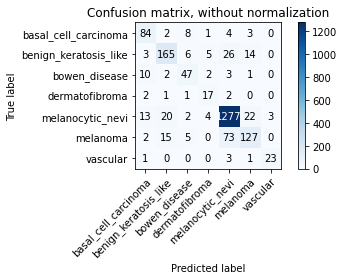

In [31]:
true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
performance_matrix(true,pred)
plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')
plt.savefig("confusion_matrix.png")